In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras import initializers
import matplotlib.pyplot as plt
import os

In [ ]:
data_dir = "./Fungi"
train_dir = "./Fungi/train"
val_dir = "./Fungi/valid"
test_dir = "./Fungi/test"

In [ ]:
train_generator  = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    labels = 'inferred',
    shuffle=True,
    seed=123,
    validation_split=0.02,
    image_size=(150,150),
    batch_size=128,
    subset='training')

val_generator  = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    label_mode='categorical',
    labels = 'inferred',
    shuffle=True,
    seed=123,
    validation_split=0.02,
    image_size=(150,150),
    batch_size=128,
    subset='validation')

Found 5000 files belonging to 5 classes.
Using 4900 files for training.
Found 899 files belonging to 5 classes.
Using 17 files for validation.


In [ ]:
EffB7_Layer = tf.keras.applications.efficientnet.EfficientNetB7(
    input_shape=(150,150, 3),
    weights='imagenet',
    include_top=False)
EffB7_Layer.trainable = False

In [ ]:
model = tf.keras.models.Sequential()
model.add(EffB7_Layer)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(2048, activation='relu', kernel_initializer='he_normal'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(1024, activation='relu', kernel_initializer='he_normal'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(512, activation='relu', kernel_initializer='he_normal'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_normal'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(5, activation='softmax', kernel_initializer='he_normal'))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)     │ (None, 5, 5, 2560)     │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 64000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64000)          │       256,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2048)           │   131,074,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 199,259,612 (760.12 MB)

 Trainable params: 135,024,133 (515.08 MB)

 Non-trainable params: 64,235,479 (245.04 MB)

In [ ]:
model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy'])

In [ ]:
class EarlyStop(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('loss') is not None and logs.get('accuracy') > 0.95 and logs.get('val_accuracy')  > 0.95:
            print("\nReached wanted accuracy so cancelling training!")
            self.model.stop_training = True
early_stop_cb = EarlyStop()

In [ ]:
epochs_len = 40
history = model.fit(
    train_generator,
    epochs=epochs_len,
    batch_size=128,
    verbose=1,
    validation_data=val_generator,
    callbacks=[early_stop_cb])

Epoch 1/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 322s 7s/step - accuracy: 0.4747 - loss: 1.3840 - val_accuracy: 0.5294 - val_loss: 1.3562
Epoch 2/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 274s 7s/step - accuracy: 0.7275 - loss: 0.7031 - val_accuracy: 0.7059 - val_loss: 0.7931
Epoch 3/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 273s 7s/step - accuracy: 0.8088 - loss: 0.5302 - val_accuracy: 0.4706 - val_loss: 1.0488
Epoch 4/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 269s 7s/step - accuracy: 0.8409 - loss: 0.4460 - val_accuracy: 0.5294 - val_loss: 0.9375
Epoch 5/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 273s 7s/step - accuracy: 0.8818 - loss: 0.3507 - val_accuracy: 0.4118 - val_loss: 1.2825
Epoch 6/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 274s 7s/step - accuracy: 0.9082 - loss: 0.3024 - val_accuracy: 0.5294 - val_loss: 1.1763
Epoch 7/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 273s 7s/step - accuracy: 0.9036 - loss: 0.2853 - val_accuracy: 0.5294 - val_loss: 1.2427
Epoch 8/40
39/39 ━━━━━━━━━━━━━━━━━━━━ 266s 7s/step - accuracy: 0.9279 - loss: 0.2319 - val_accuracy: 0.6471 - v

In [ ]:
model.save('./Fungi/model.h5')
#save model supaya bisaa trial tanpa harus train ulang
#trial dilanjut di Test Model.ipynb

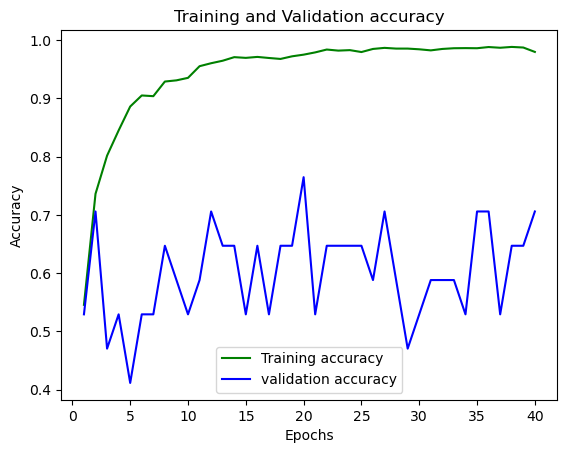

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1,history.epoch[-1]+2)
plt.plot(epochs, train_accuracy, 'g', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

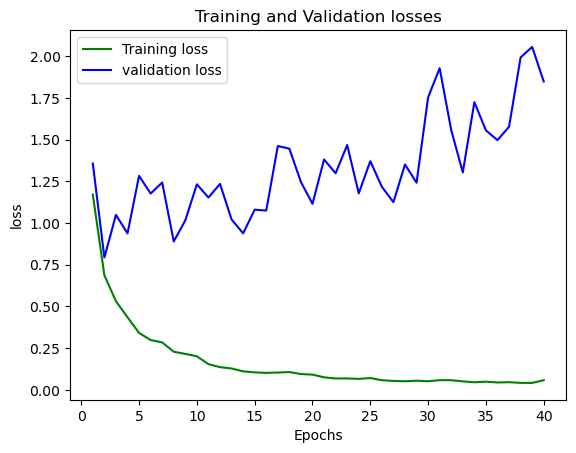

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, train_loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('Training and Validation losses')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
    path = fn
    img = image.load_img(path, target_size=(150, 150))

    imgplot = plt.imshow(img)

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])

    classes = model.predict(images, batch_size=10)

    print(fn)
    print(classes)

    class_index = np.argmax(classes[0])
    class_probability = classes[0][class_index]

    threshold = 0.5

    if class_probability >= threshold:
        if class_index == 0:
            print('This is Candida Albicans')
        elif class_index == 1:
            print('This is Aspergillus Niger')
        elif class_index == 2:
            print('This is Trichophyton Rubrum')
        elif class_index == 3:
            print('This is Trichophyton Mentagrophytes')
        elif class_index == 4:
            print('This is Epidermophyton Floccosum')
    else:
        print('Unknown')
